# The Northwind Database: Do discounts matter and Other Analysis

Northwind Traders Access database is a sample database that was created by Microsoft. The database houses sales data for a fictitious company called Northwind Traders, which imports and exports specialty foods from around the world. 

Below you can see the schema for the database.  The Schema provided below has some typos in it so some of our code will be slightly different than what is listed in the map.

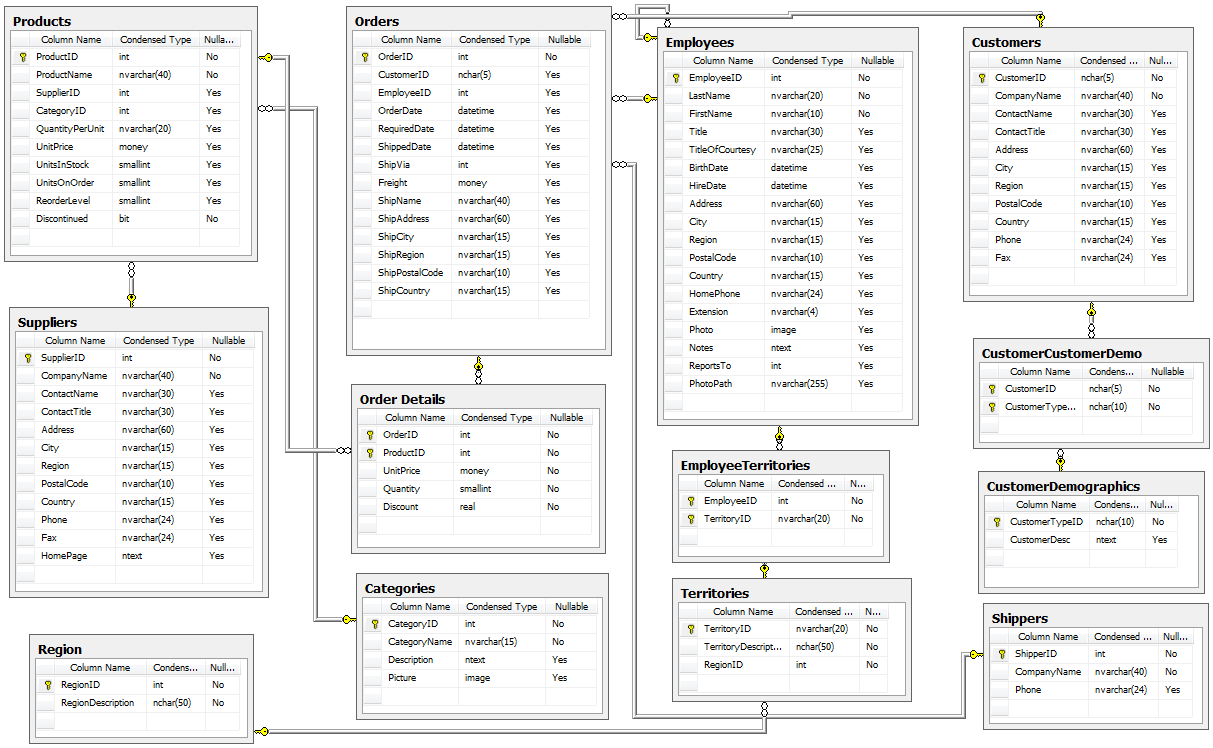

## Let's Ask Our First Question

### Do discounts have a statistically significant effect on the number of products customers order? If so, at what level(s) of discount?

The test we will perform will be at a 5% alpha or a 95% confidence level.  Since we are doing hypothesis testing we should also clearly state our null and alternate hypothesis:

Null Hypothesis =  Ho: There is no effect of Discount on the number of products per order

Alternate Hypothesis = Ha: There is a positive effect of having a discount and the number of products per order.

We'll start with importing some of the necessary libraries.  We will certainly add more as we work through our analysis, but this should get us started.

Then we'll use some SQL joins to get all the necessary data from the database and into a pandas dataframe.

In [1]:
# Importing the required libraries
import sqlite3 
import pandas as pd
from pandasql import sqldf
import numpy as np

#keeping our notebook clean by ignoring filter warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Creating a connection and cursor with SQLite
conn = sqlite3.connect('Northwind_small.sqlite',detect_types=sqlite3.PARSE_COLNAMES)
cur = conn.cursor()

In [3]:
# Extracting the data required as a pandas dataframe using a SQL query
cur.execute("""SELECT * FROM orderdetail;""")

df = pd.DataFrame(cur.fetchall()) #Take results and create dataframe
df.columns = [i[0] for i in cur.description]
df.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248/11,10248,11,14.0,12,0.0
1,10248/42,10248,42,9.8,10,0.0
2,10248/72,10248,72,34.8,5,0.0
3,10249/14,10249,14,18.6,9,0.0
4,10249/51,10249,51,42.4,40,0.0


We're going to remove the ID column because pandas to make our table cleaner.

In [4]:
#dropping the id column and checking the resulting dataframe
df = df.drop('Id', axis =1)
df.head()

,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248,11,14.0,12,0.0
1,10248,42,9.8,10,0.0
2,10248,72,34.8,5,0.0
3,10249,14,18.6,9,0.0
4,10249,51,42.4,40,0.0


Great, the data loaded properly.  Now we can get a feel for our data. So we can look at various summary statistics to see what exactly we have to work with.

In [5]:
#looking at the info to see what type of data we have
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2155 entries, 0 to 2154
Data columns (total 5 columns):
OrderId      2155 non-null int64
ProductId    2155 non-null int64
UnitPrice    2155 non-null float64
Quantity     2155 non-null int64
Discount     2155 non-null float64
dtypes: float64(2), int64(3)
memory usage: 84.3 KB


In [6]:
#checking our summary statistics
df.describe()

,OrderId,ProductId,UnitPrice,Quantity,Discount
count,2155.000000,2155.000000,2155.000000,2155.000000,2155.000000
mean,10659.375870,40.793039,26.218520,23.812993,0.056167
std,241.378032,22.159019,29.827418,19.022047,0.083450
min,10248.000000,1.000000,2.000000,1.000000,0.000000
25%,10451.000000,22.000000,12.000000,10.000000,0.000000
50%,10657.000000,41.000000,18.400000,20.000000,0.000000
75%,10862.500000,60.000000,32.000000,30.000000,0.100000
max,11077.000000,77.000000,263.500000,130.000000,0.250000


I want to know how many orders there are so we're also taking a look at the unique values in the OrderID column 

In [7]:
len(df.OrderId.unique())

830

So we have 830 individual orders, with an average order of 23 items per order.  Let's see what the distribution looks like next.

In [8]:
#importing our visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

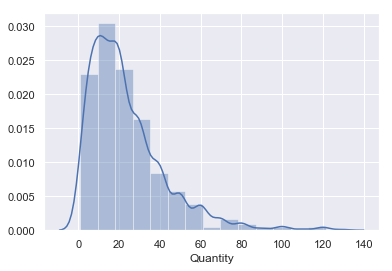

In [9]:
#looking at our plot
sns.set(); np.random.seed(0)
ax = sns.distplot(df.Quantity, bins=15, hist=True)


Let's look at another plot and start to formulate the answer to our first question.

We're going to look at quantity only where discounts are not 0!

In [24]:
#making a dataframe copy and then slicing only the part of the database where a discount was applied (i.e. Discount>0)
disc_df = df.copy()

disc_df = disc_df.loc[disc_df['Discount'] > 0]
disc_df.head()

,OrderId,ProductId,UnitPrice,Quantity,Discount
6,10250,51,42.4,35,0.15
7,10250,65,16.8,15,0.15
8,10251,22,16.8,6,0.05
9,10251,57,15.6,15,0.05
11,10252,20,64.8,40,0.05


In [27]:
#looking at new summary statistics
disc_df.describe()

,OrderId,ProductId,UnitPrice,Quantity,Discount
count,838.000000,838.000000,838.000000,838.000000,838.000000
mean,10654.007160,39.844869,26.292363,27.109785,0.144439
std,235.887125,22.046812,30.017214,20.771439,0.071808
min,10250.000000,1.000000,2.000000,1.000000,0.010000
25%,10452.250000,21.000000,12.500000,12.000000,0.100000
50%,10645.000000,40.000000,18.000000,20.000000,0.150000
75%,10847.000000,59.000000,31.230000,36.000000,0.200000
max,11077.000000,77.000000,263.500000,130.000000,0.250000


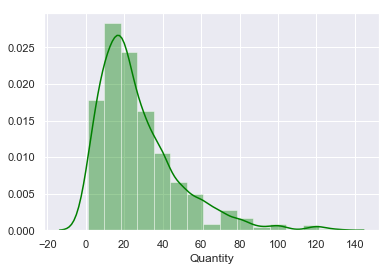

In [26]:
#looking at the new plot - this is for infromation gathering, we will be operating on our original dataframe
ax2 = sns.distplot(disc_df.Quantity, bins=15, hist=True, color = 'green')

Much smoother.  Our data still looks heavily skewed right (long right tail) so using an ANOVA test for our hyposthesis wouldn't work well.  To fix this what we can do is log-transform the data to get closer to a normal distribution.  Then we can do our first test.

In [53]:
# we're going to show our test statistics using our first dataframe - that's the data we are really after
df_log = df.copy()
disc_df_log = disc_df.copy()

df_log['Quantity']=np.log(df['Quantity'])
disc_df_log['Quantity']=np.log(disc_df['Quantity'])

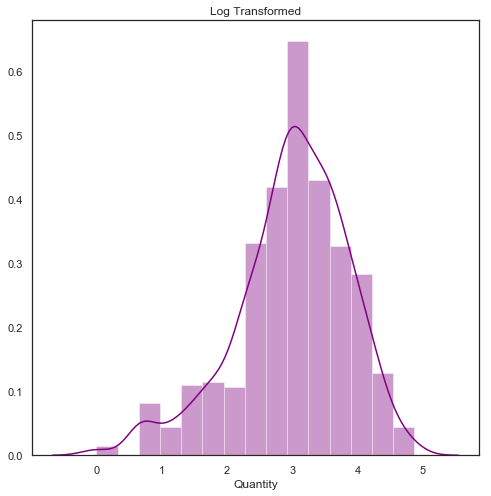

In [54]:
#plotting again with our logtransformed data
sns.set(style="white", palette="muted", color_codes=True)
f = plt.figure(figsize=(8,8))

ax_log = sns.distplot(disc_df_log.Quantity, bins=15, hist=True, color = 'purple')

ax_log.set_title('Log Transformed')

plt.show()

This is bell curve is more normal and given the number of observations we can move forward now.

In [48]:
#importing the statistical packages we plan to use
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [49]:
# Fitting a model of price_per_order on Region categories, and using statsmodels to compute an ANOVA table
lm = ols('Quantity ~ C(Discount)', df_log).fit()
sm.stats.anova_lm(lm, typ=2)

,sum_sq,df,F,PR(>F)
C(Discount),82.463740,10.0,11.311846,4.349593e-19
Residual,1562.983265,2144.0,NaN,NaN


The ANOVA table above shows a p-value that is lower than the alpha value of 5% (0.05). 

Therefore, we are able to reject the null hypothesis and accept the alternative hypothesis.  

Great!  This is part a of our question answered.  Now what about part b?  Just how significant is this effect?

We can use Cohen's d to quanitfy the effect.  Before we do that we have a little bit more work to do.

The data was already split into a dataframe with just those purchases that have discounts.  We'll need to pull the other sub-set of the data, those with no discounts, into a separate dataframe as well, for ease of calculation.  

In [55]:
#making a dataframe copy and then slicing our dataframe as above
nodisc_df = df.copy()

nodisc_df = nodisc_df.loc[nodisc_df['Discount'] == 0]
nodisc_df.head()

,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248,11,14.0,12,0.0
1,10248,42,9.8,10,0.0
2,10248,72,34.8,5,0.0
3,10249,14,18.6,9,0.0
4,10249,51,42.4,40,0.0


In [56]:
#looking at summary statistics
nodisc_df.describe()

,OrderId,ProductId,UnitPrice,Quantity,Discount
count,1317.000000,1317.000000,1317.000000,1317.000000,1317.0
mean,10662.791951,41.396355,26.171534,21.715262,0.0
std,244.835366,22.217410,29.717354,17.507493,0.0
min,10248.000000,1.000000,2.000000,1.000000,0.0
25%,10448.000000,23.000000,12.000000,10.000000,0.0
50%,10671.000000,41.000000,18.400000,18.000000,0.0
75%,10879.000000,60.000000,32.800000,30.000000,0.0
max,11077.000000,77.000000,263.500000,130.000000,0.0


In [52]:
#log transforming our new slice 
nodisc_df_log['Quantity']=np.log(nodisc_df['Quantity'])

NameError: name 'nodisc_df_log' is not defined

In [ ]:
def Cohen_d(group1, group2):

    # Compute Cohen's d.

    # group1: Series or NumPy array
    # group2: Series or NumPy array

    # returns a floating point number 

    diff = group1.mean() - group2.mean()

    n1, n2 = len(group1), len(group2)
    var1 = group1.var()
    var2 = group2.var()

    # Calculate the pooled threshold as shown earlier
    pooled_var = (n1 * var1 + n2 * var2) / (n1 + n2)
    
    # Calculate Cohen's d statistic
    d = diff / np.sqrt(pooled_var)
    
    return d